In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'raw'
model_setting = 'conv1d'

In [2]:
d = Dataset('Wingbeats')
d.read(loadmat=False)

Species: all.
Read 279566 filenames in 0.71 seconds.


In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False)

Species: Ae. aegypti.
Read 85553 filenames in 1.49 seconds.
['20170209', '20161213', '20161212', '20170212', '20170208', '20170207', '20170206', '20170210', '20170211', '20170213']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.51 seconds.
['20170228', '20170103', '20170301', '20170227', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.47 seconds.
['20170203', '20170204', '20170318', '20170202', '20170130', '20170319', '20170201', '20170315', '20170316', '20170314', '20170205', '20170317', '20170131', '20170206', '20170313', '20170320']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.47 seconds.
['20170109', '20170110', '20170120', '20170121', '20170122', '20170117', '20170123', '20170116', '20170119', '20170118']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Read 74599 filenames in 1.49 seconds.
['20161220', '2016

In [4]:
X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

In [5]:
using_conv2d = False
traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=f'TL_{splitting}_{data_setting}_{model_setting}_weights')
model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config

############ INPUT SHAPE:(5000, 1)


In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# model.load_weights('../temp_data/custom_raw_conv1d_0.h5')

In [8]:
# train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

In [9]:
h = model.fit_generator(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=traincf.target_names,
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=using_conv2d),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=traincf.target_names,
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats='',
                                                        using_conv2d=using_conv2d),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Epoch 1/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.3941 - accuracy: 0.8622
Epoch 00001: val_loss improved from inf to 1.93834, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_custom_raw_conv1d_weights.h5
5718/5718 [==============================] - 413s 72ms/step - loss: 0.3941 - accuracy: 0.8622 - val_loss: 1.9383 - val_accuracy: 0.6764
Epoch 2/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.9100
Epoch 00002: val_loss improved from 1.93834 to 1.85837, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_custom_raw_conv1d_weights.h5
5718/5718 [==============================] - 413s 72ms/step - loss: 0.2581 - accuracy: 0.9100 - val_loss: 1.8584 - val_accuracy: 0.6484
Epoch 3/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9230
Epoch 00003: val_loss did not improve from 1.85837
5718/5718 [==============================] - 412s 72ms/step - lo

In [11]:
features = model.predict_generator(valid_generator(X_test, y_test, 
                                                  batch_size=traincf.batch_size, 
                                                  setting=traincf.setting, 
                                                  target_names=traincf.target_names,
                                                  preprocessing_train_stats=''),
                                  steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

In [12]:
features.shape

(47295, 6)

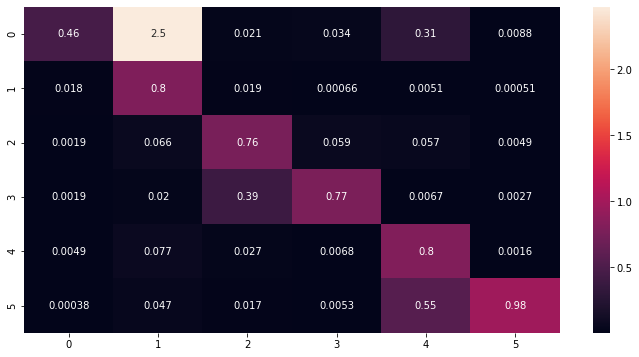

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(12,6))
cm = confusion_matrix(np.argmax(features, axis=1), y_test)
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)
sb.heatmap(cm, annot=True)